In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import cv2

2024-04-01 15:31:04.337542: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-01 15:31:04.337651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-01 15:31:04.494395: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
SEED = 15243
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
tf.random.set_seed(SEED)
plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif")

In [3]:
BATCH_SIZE = 25
DATA_DIR = ("/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets")
 
IMG_SIZE = 256
MAX_EPOCHS = 100
class_names = ["lung_n", "lung_aca", "lung_scc"]
class_details = ["No Cancer", "Adenocarcinoma", "Squamous Cell Carcinoma"]

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    subset="training",
    validation_split=0.2
)

Found 15000 files belonging to 3 classes.
Using 12000 files for training.


In [5]:
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATA_DIR,
    batch_size=BATCH_SIZE,
    image_size=(IMG_SIZE, IMG_SIZE),
    class_names=class_names,
    seed=45,
    subset="validation", 
    validation_split=0.2
)

Found 15000 files belonging to 3 classes.
Using 3000 files for validation.


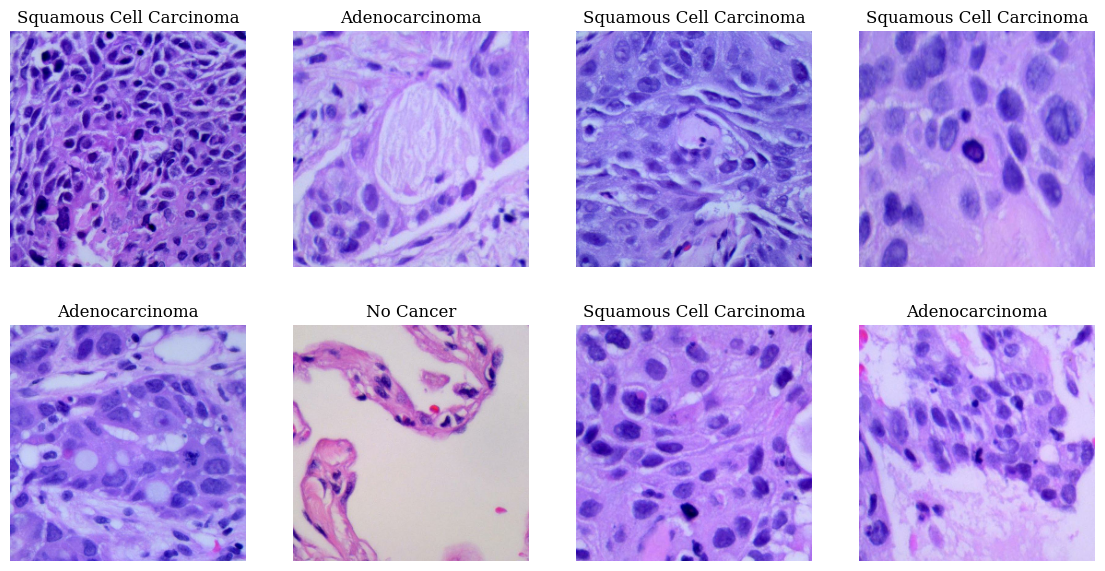

In [6]:
plt.figure(figsize=(14, 7))
for images, labels in train_ds.take(1):
    labels = labels.numpy()
    for i in range(8):
        ax = plt.subplot(2, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_details[labels[i]])
        plt.axis("off")

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache(".cached-data").prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
def compile_and_fit_model(model: tf.keras.Sequential) -> tf.keras.callbacks.History:
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-4,
        patience=5,
        mode="auto",
        restore_best_weights=True
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.2,
        patience=5,
        min_lr=0.001
    )
    history = model.fit(
        train_ds,
        validation_data=validation_ds,
        epochs=MAX_EPOCHS,
        steps_per_epoch=50,
        callbacks=[early_stopping, reduce_lr]
    )
    performance_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for ax, metric in zip(axes.flat, ["accuracy", "loss"]):
        performance_df.filter(like=metric).plot(ax=ax)
        ax.set_title(metric.title(), size=15, pad=20)
    return history

In [8]:
pretrained_efficientnet_base = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False, weights="imagenet", pooling="avg",
)
pretrained_efficientnet_base.trainable = False
efficientnet_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    pretrained_efficientnet_base,
    layers.Dense(128, activation="relu"),
    layers.Dense(3, activation="softmax")
])
efficientnet_model.summary()

27018416/27018416 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional  (None, 1280)              6575239   
 )                                                               
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 6739594 (25.71 MB)
Trainable params: 164355 (642.01 KB)
Non-trainable params: 6575239 (25.08 MB)
_________________________________________________________________


Epoch 1/100


2024-04-01 15:31:51.657213: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1711985515.543982     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 [==============================] - 33s 394ms/step - loss: 0.2633 - accuracy: 0.8832 - val_loss: 0.1419 - val_accuracy: 0.9490 - lr: 0.0010
Epoch 2/100
50/50 [==============================] - 13s 264ms/step - loss: 0.1642 - accuracy: 0.9360 - val_loss: 0.1049 - val_accuracy: 0.9593 - lr: 0.0010
Epoch 3/100
50/50 [==============================] - 13s 267ms/step - loss: 0.0986 - accuracy: 0.9600 - val_loss: 0.0813 - val_accuracy: 0.9683 - lr: 0.0010
Epoch 4/100
50/50 [==============================] - 13s 264ms/step - loss: 0.1062 - accuracy: 0.9568 - val_loss: 0.0907 - val_accuracy: 0.9610 - lr: 0.0010
Epoch 5/100
50/50 [==============================] - 13s 264ms/step - loss: 0.0734 - accuracy: 0.9760 - val_loss: 0.0814 - val_accuracy: 0.9697 - lr: 0.0010
Epoch 6/100
50/50 [==============================] - 13s 266ms/step - loss: 0.0774 - accuracy: 0.9728 - val_loss: 0.0626 - val_accuracy: 0.9783 - lr: 0.0010
Epoch 7/100
50/50 [==============================] - 13s 267ms/step - 

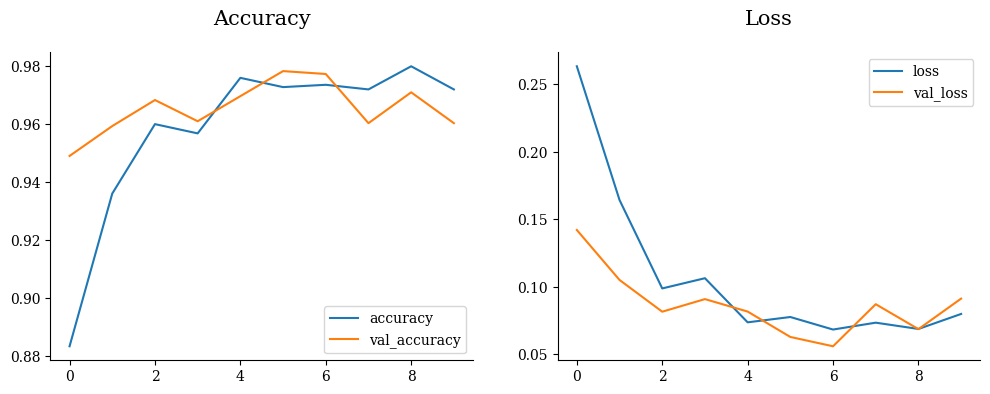

In [9]:
efficientnet_history = compile_and_fit_model(efficientnet_model)

In [10]:
'''def get_predictions(model, dataset):
    y_true = []
    y_pred = []

    for images, labels in dataset:
        y_true.extend(labels.numpy())
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))

    return np.array(y_true), np.array(y_pred)


train_true, train_pred = get_predictions(efficientnet_model, train_ds)
val_true, val_pred = get_predictions(efficientnet_model, validation_ds)

train_conf_matrix = confusion_matrix(train_true, train_pred)
train_class_report = classification_report(train_true, train_pred, target_names=class_details)

val_conf_matrix = confusion_matrix(val_true, val_pred)
val_class_report = classification_report(val_true, val_pred, target_names=class_details)

print("Confusion Matrix (Training Set):\n", train_conf_matrix)
print("\nClassification Report (Training Set):\n", train_class_report)

print("\nConfusion Matrix (Validation Set):\n", val_conf_matrix)
print("\nClassification Report (Validation Set):\n", val_class_report)'''


'def get_predictions(model, dataset):\n    y_true = []\n    y_pred = []\n\n    for images, labels in dataset:\n        y_true.extend(labels.numpy())\n        predictions = model.predict(images)\n        y_pred.extend(np.argmax(predictions, axis=1))\n\n    return np.array(y_true), np.array(y_pred)\n\n\ntrain_true, train_pred = get_predictions(efficientnet_model, train_ds)\nval_true, val_pred = get_predictions(efficientnet_model, validation_ds)\n\ntrain_conf_matrix = confusion_matrix(train_true, train_pred)\ntrain_class_report = classification_report(train_true, train_pred, target_names=class_details)\n\nval_conf_matrix = confusion_matrix(val_true, val_pred)\nval_class_report = classification_report(val_true, val_pred, target_names=class_details)\n\nprint("Confusion Matrix (Training Set):\n", train_conf_matrix)\nprint("\nClassification Report (Training Set):\n", train_class_report)\n\nprint("\nConfusion Matrix (Validation Set):\n", val_conf_matrix)\nprint("\nClassification Report (Valida

1/1 [==============================] - 0s 40ms/step


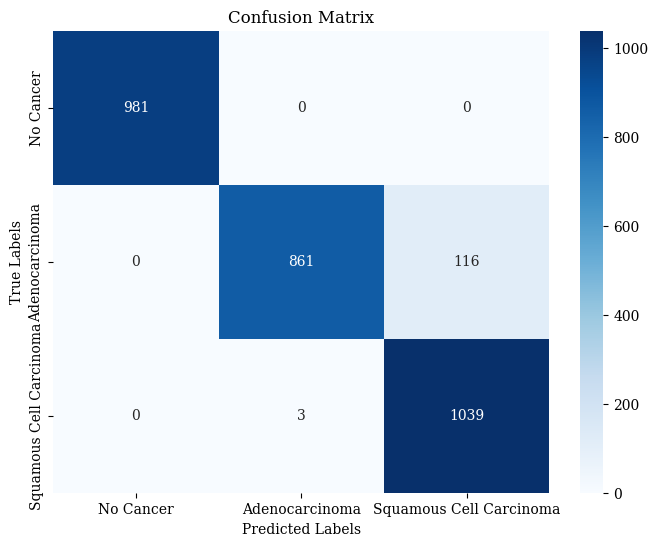

Classification Report:
                         precision    recall  f1-score   support

              No Cancer       1.00      1.00      1.00       981
         Adenocarcinoma       1.00      0.88      0.94       977
Squamous Cell Carcinoma       0.90      1.00      0.95      1042

               accuracy                           0.96      3000
              macro avg       0.97      0.96      0.96      3000
           weighted avg       0.96      0.96      0.96      3000



In [11]:
validation_predictions = []
validation_labels = []

for images, labels in validation_ds:
    validation_predictions.extend(np.argmax(efficientnet_model.predict(images), axis=1))
    validation_labels.extend(labels.numpy())

conf_matrix = confusion_matrix(validation_labels, validation_predictions)

class_report = classification_report(validation_labels, validation_predictions, target_names=class_details)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_details, yticklabels=class_details)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(class_report)


lungaca10.jpeg
1/1 [==============================] - 1s 1s/step
[[2.8404582e-05 9.9996638e-01 5.1903121e-06]]


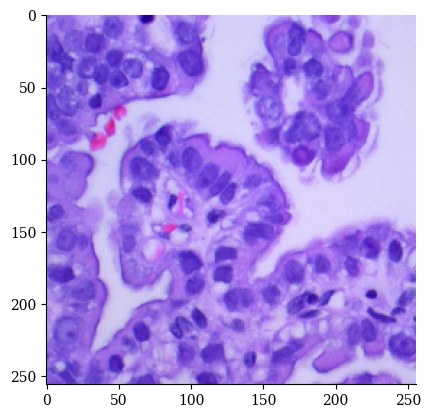

THE UPLOADED IMAGE IS SUSPECTED AS: adinocarcinoma
lungscc1007.jpeg
1/1 [==============================] - 0s 30ms/step
[[2.0589576e-08 8.1440201e-04 9.9918562e-01]]


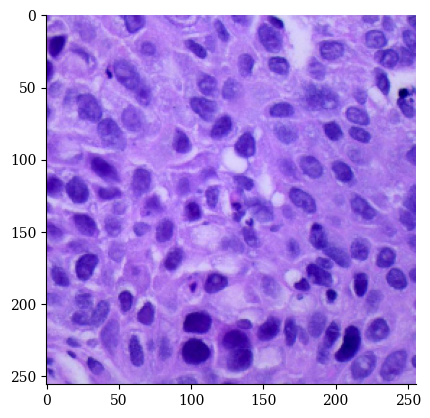

THE UPLOADED IMAGE IS SUSPECTED AS: squamous cell carcinoma
lungaca1013.jpeg
1/1 [==============================] - 0s 32ms/step
[[7.572352e-04 9.987735e-01 4.692499e-04]]


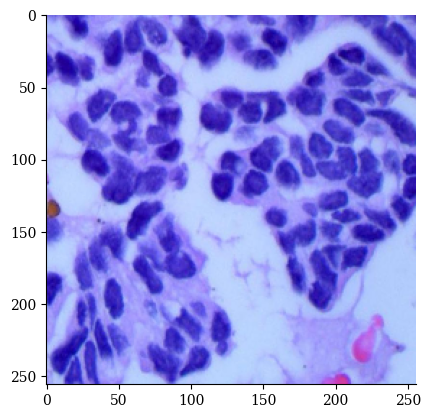

THE UPLOADED IMAGE IS SUSPECTED AS: adinocarcinoma
lungn1009.jpeg
1/1 [==============================] - 0s 30ms/step
[[9.9999678e-01 3.1839709e-06 9.6623598e-09]]


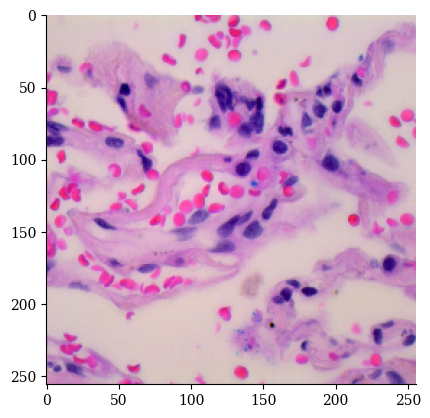

THE UPLOADED IMAGE IS SUSPECTED AS: no cancer 
lungn1011.jpeg
1/1 [==============================] - 0s 30ms/step
[[9.9987662e-01 1.2273827e-04 5.5031956e-07]]


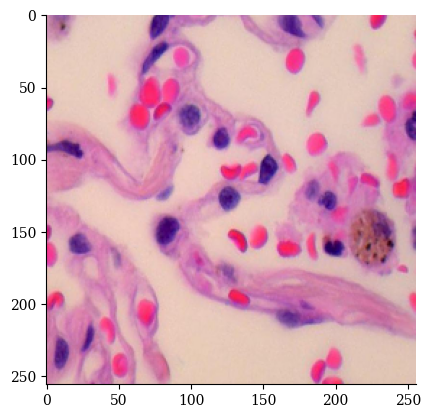

THE UPLOADED IMAGE IS SUSPECTED AS: no cancer 
lungaca1010.jpeg
1/1 [==============================] - 0s 30ms/step
[[7.0734782e-06 9.9920624e-01 7.8676629e-04]]


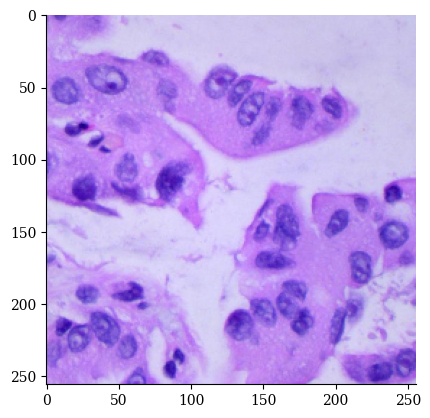

THE UPLOADED IMAGE IS SUSPECTED AS: adinocarcinoma
lungn1019.jpeg
1/1 [==============================] - 0s 30ms/step
[[9.9979693e-01 2.0269291e-04 3.6211517e-07]]


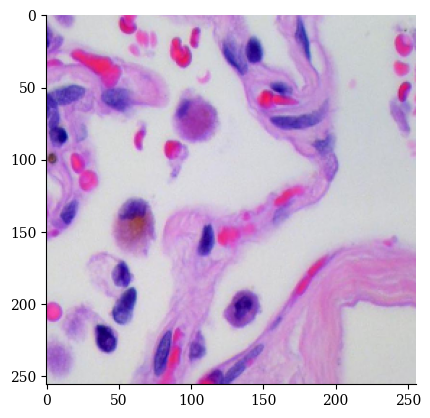

THE UPLOADED IMAGE IS SUSPECTED AS: no cancer 
lungscc100.jpeg
1/1 [==============================] - 0s 29ms/step
[[2.4100750e-09 1.2405758e-05 9.9998760e-01]]


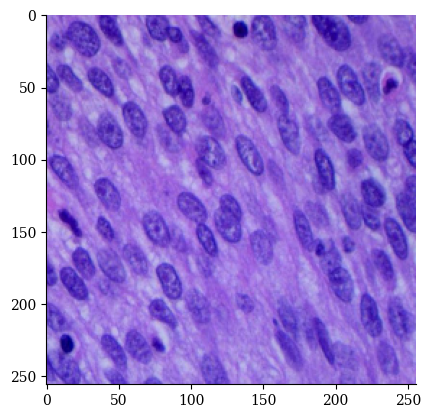

THE UPLOADED IMAGE IS SUSPECTED AS: squamous cell carcinoma
lungscc1010.jpeg
1/1 [==============================] - 0s 31ms/step
[[4.0803428e-08 2.5102727e-02 9.7489727e-01]]


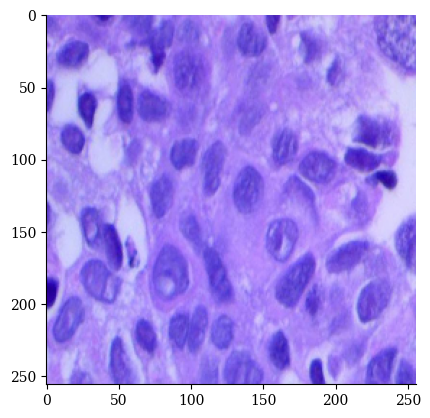

THE UPLOADED IMAGE IS SUSPECTED AS: squamous cell carcinoma
lungscc1.jpeg
1/1 [==============================] - 0s 33ms/step
[[2.4777516e-09 6.8083033e-04 9.9931920e-01]]


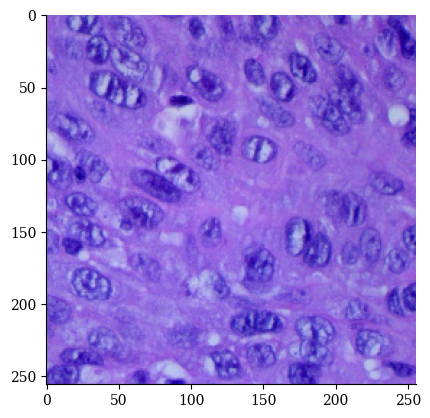

THE UPLOADED IMAGE IS SUSPECTED AS: squamous cell carcinoma
lungscc1005.jpeg
1/1 [==============================] - 0s 31ms/step
[[2.2098314e-08 3.5357254e-04 9.9964643e-01]]


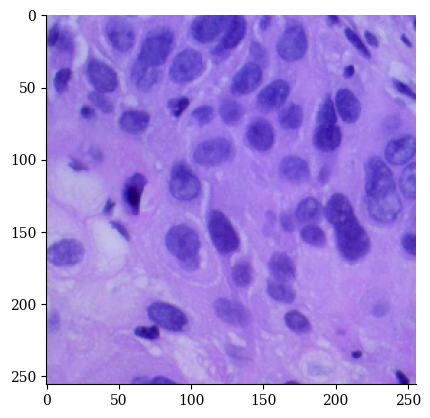

THE UPLOADED IMAGE IS SUSPECTED AS: squamous cell carcinoma
lungaca1.jpeg
1/1 [==============================] - 0s 30ms/step
[[8.5493220e-06 9.9021775e-01 9.7737452e-03]]


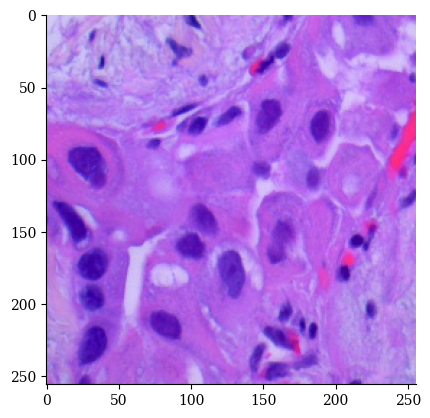

THE UPLOADED IMAGE IS SUSPECTED AS: adinocarcinoma
lungn1000.jpeg
1/1 [==============================] - 0s 29ms/step
[[9.9999630e-01 3.6429306e-06 3.0045606e-09]]


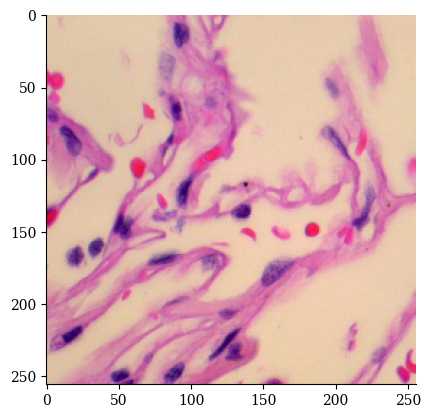

THE UPLOADED IMAGE IS SUSPECTED AS: no cancer 
lungn1.jpeg
1/1 [==============================] - 0s 35ms/step
[[9.9928230e-01 7.1495719e-04 2.7659325e-06]]


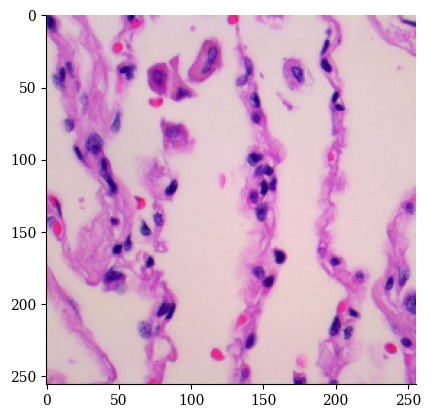

THE UPLOADED IMAGE IS SUSPECTED AS: no cancer 
lungaca1023.jpeg
1/1 [==============================] - 0s 30ms/step
[[1.4573052e-05 9.9216568e-01 7.8197625e-03]]


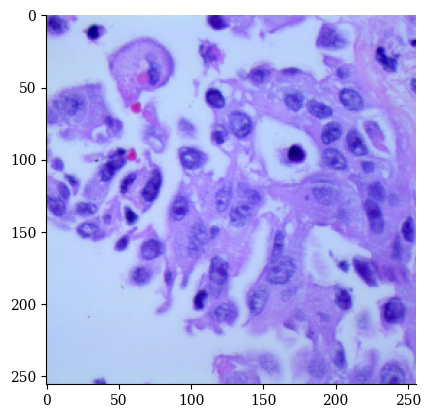

THE UPLOADED IMAGE IS SUSPECTED AS: adinocarcinoma


In [12]:
prediction_folder="/kaggle/input/prediction-set/pred"
image_files = os.listdir(prediction_folder)
from keras.preprocessing import image 
model=efficientnet_model
for image_file in image_files:
    print(image_file)
    img = os.path.join(prediction_folder, image_file)
    img = image.load_img(img,target_size=(IMG_SIZE, IMG_SIZE))
    imag = image.img_to_array(img)
    imaga = np.expand_dims(imag,axis=0) 
    ypred = model.predict(imaga)
    print(ypred)
    a=np.argmax(ypred,-1)
    if a==0:
          op="no cancer "
    elif a==1:
          op="adinocarcinoma"
    else:
          op="squamous cell carcinoma"    
    plt.imshow(img)
    plt.show() 
    print("THE UPLOADED IMAGE IS SUSPECTED AS: "+str(op)) 